In [1278]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import math
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndimage

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../../input/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [1279]:
# Load the scans in given folder path
def load_scan(path):
    print('Loading scan at ' + path)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [1280]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Loading scan at ../../input/sample_images/0c60f4b87afcb3e2dfa65abbbf3ef2f9


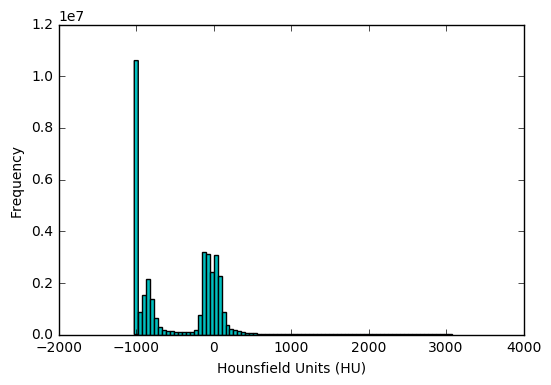

(136, 512, 512)


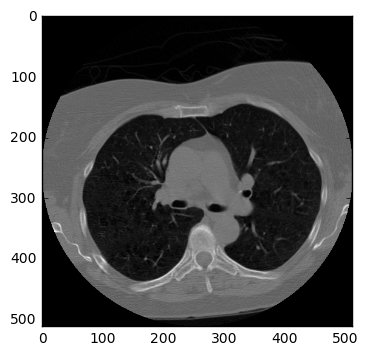

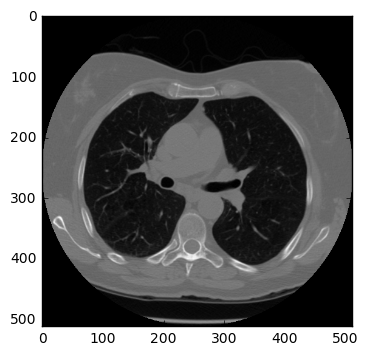

Loading scan at ../../input/sample_images/0ca943d821204ceb089510f836a367fd


In [1281]:
#for p in patients:
first_patient = load_scan(INPUT_FOLDER + '0c60f4b87afcb3e2dfa65abbbf3ef2f9')
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
print(np.shape(first_patient_pixels))
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

plt.imshow(second_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

second_patient = load_scan(INPUT_FOLDER + '0ca943d821204ceb089510f836a367fd')
second_patient_pixels = get_pixels_hu(second_patient)

In [1282]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    #put all images with the same dimensions
    image = scipy.ndimage.interpolation.affine_transform(image, np.identity(3), output_shape=(500,500,500))
    
    return image, new_spacing

In [1283]:
print('First patient resampling...')
first_pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

print('Second patient resampling...')
second_pix_resampled, spacing = resample(second_patient_pixels, second_patient, [1,1,1])
print("Shape 2 before resampling\t", second_patient_pixels.shape)
print("Shape 2 after resampling\t", pix_resampled.shape)


First patient resampling...
Shape before resampling	 (136, 512, 512)
Shape after resampling	 (500, 500, 500)
Second patient resampling...
Shape 2 before resampling	 (147, 512, 512)
Shape 2 after resampling	 (500, 500, 500)


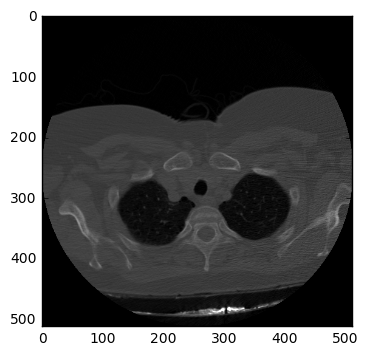

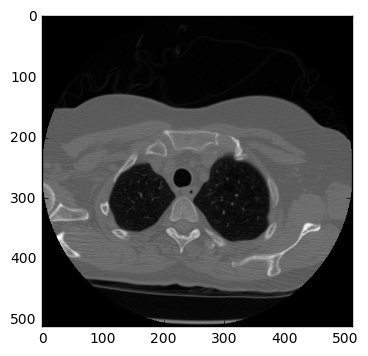

In [1284]:
plt.imshow(first_patient_pixels[120], cmap=plt.cm.gray)
plt.show()
plt.imshow(second_patient_pixels[120], cmap=plt.cm.gray)
plt.show()

In [1286]:
#plot_3d(pix_resampled, 800)

In [1312]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):

#     print('orign image')
#     plt.imshow(image[120], cmap=plt.cm.gray)
#     plt.show()
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    
#     print('binary_image image')
#     plt.imshow(binary_image[120], cmap=plt.cm.gray)
#     plt.show()
    
    labels = measure.label(binary_image)

#     print('labels image')
#     plt.imshow(labels[120], cmap=plt.cm.gray)
#     plt.show()
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0] 
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2

#     print('fill the air image')
#     plt.imshow(binary_image[120], cmap=plt.cm.gray)
#     plt.show()
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0

    return binary_image

In [1313]:
print('Segmenting patient 1 lungs')
# first_segmented_lungs = segment_lung_mask(first_pix_resampled, False)
first_segmented_lungs_fill_raw = segment_lung_mask(first_pix_resampled, True)

print('Segmenting patient 2 lungs')
# second_segmented_lungs = segment_lung_mask(second_pix_resampled, False)
second_segmented_lungs_fill_raw = segment_lung_mask(second_pix_resampled, True)


Segmenting patient 1 lungs
Segmenting patient 2 lungs


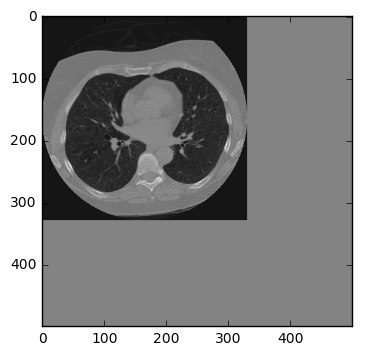

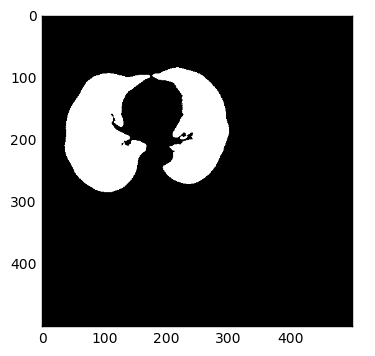

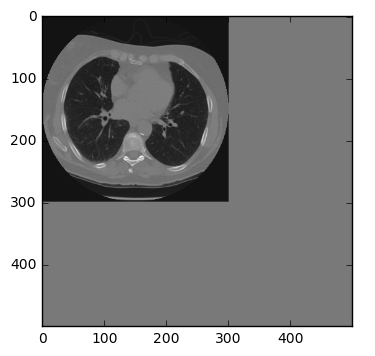

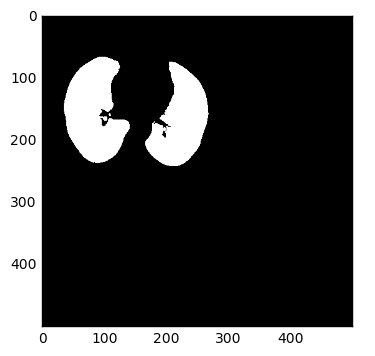

In [1314]:
plt.imshow(first_pix_resampled[120], cmap=plt.cm.gray)
plt.show()
plt.imshow(first_segmented_lungs_fill_raw[120], cmap=plt.cm.gray)
plt.show()
plt.imshow(second_pix_resampled[120], cmap=plt.cm.gray)
plt.show()
plt.imshow(second_segmented_lungs_fill_raw[120], cmap=plt.cm.gray)
plt.show()


# Centering lungs on 3D image volume (Stutz)
For better CNN performance, we would align everything that is possible between training/test images

In [1315]:
#bounding box for N-dimensional img
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import itertools
from itertools import product, combinations
from scipy import ndimage

#this function changes axis references
#img is in format [img-n, y, x]
#returns array in format [bound-x, bound-y, bound-z]
# def boundingBox(img):
#     N = np.ndim(img)
#     out = []
#     for ax in itertools.combinations(range(N), N - 1):
#         print('ax', ax)
#         nonzero = np.any(img, axis=ax)
#         out.extend(np.where(nonzero)[0][[0, -1]])
#     return np.reshape(np.asarray(tuple(out)), (-1, 2))

# def boundingBox(img, threshold=0.5):
#     depth = np.any(img, axis=2)
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     dmin, dmax = np.where(depth)[0][[0, -1]]
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     print(np.where(np.any(img, axis=2)))
#     return dmin, dmax, rmin, rmax, cmin, cmax

#returns bounds in format [(x1,y1,z1),(x2,y2,z2)]
def boundingBox(img):
    N = img.ndim
    out = []
    for ax in itertools.combinations(range(N), N - 1):
        nonzero = np.any(img, axis=ax)
        out.extend(np.where(nonzero)[0][[0, -1]])
    r = np.reshape(np.asarray(tuple(out)), (-1, 2)).T
    return [tuple(r[0]), tuple(r[1])]

print(boundingBox(im))

[(1, 1), (6, 6)]


In [1316]:
import random

#bounds in format [(x1,y1,z1),(x2,y2,z2)]
def boundingBoxCenter(bounds):
    return (int(round((bounds[0][0] + (bounds[1][0]-bounds[0][0])/2))), int(round((bounds[0][1] + (bounds[1][1]-bounds[0][1])/2))), int(round((bounds[0][2] + (bounds[1][2]-bounds[0][2])/2))))

In [1317]:
#bounds in format [(x1,y1,z1),(x2,y2,z2)]
def plot_boundingBox(boundsList):
    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.gca(projection='3d')
    
    for bounds in boundsList:
        bounds = bounds.T
        c = "#%06x" % random.randint(0, 0xFFFFFF)
        for s, e in combinations(np.array(list(product(bounds[0],bounds[1],bounds[2]))), 2):
            if (np.sum(np.abs(s-e)) == bounds[0][1]-bounds[0][0]) or (np.sum(np.abs(s-e)) == bounds[1][1]-bounds[1][0]) or (np.sum(np.abs(s-e)) == bounds[2][1]-bounds[2][0]):
                ax.plot3D(*zip(s,e), color=c)
        t = boundingBoxCenter(bounds.T)
        ax.scatter(t[0], t[1], t[2], color=c)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(0,500)
    ax.set_ylim(0,500)
    ax.set_zlim(0,500)
    plt.show()

In [1318]:
def plot_slice(image, point=None, rectangle=None, pos=220, size=8):
  fig1, ax1 = plt.subplots(1)
  fig1.set_size_inches(size,size)
  ax1.imshow(image[pos], cmap=plt.cm.gray)
  if(point != None):
    ax1.scatter(point[0], point[1])
  if(rectangle != None):
    ax1.add_patch(patches.Rectangle((rectangle[0][0],rectangle[0][1]),rectangle[1][0]-rectangle[0][0],rectangle[1][1]-rectangle[0][1],linewidth=1,edgecolor='r',facecolor='none'))
  plt.show()

In [1405]:
#find lungs rotation by finding minimum and maximum extremities from lung halves
def find_minmax_halfx(lung_mask, xhalf, bottom2up=True, left2right=True, slicen=220):
    xsize = np.shape(lung_mask)[2]-1
    ysize = np.shape(lung_mask)[1]-1
    im = np.swapaxes(lung_mask[slicen], 0, 1)

    if(bottom2up): mvalue = (-1,0)
    else: mvalue = (-1, ysize)
        
    if(left2right): 
        xstart = 0
        xend = xhalf
        xdir = 1
    else:
        xstart = xsize
        xend = xhalf
        xdir = -1
        
    for x in range(xstart, xend, xdir):
        for y in range(ysize):
            if(not bottom2up): yi = ysize - y
            else: yi = y

            if(im[x][yi]>0.5):
                if(bottom2up and yi>mvalue[1]):
                    mvalue = (x, yi)
                elif(not bottom2up and yi<mvalue[1]):
                    mvalue = (x, yi)
    return mvalue
    
def calculate_angle(p1, p2):
    return math.degrees(math.atan2(p2[1]-p1[1],p2[0]-p1[0]))

def value_between(value, min_value, max_value):
    if(value<min_value): return False
    if(value>max_value): return False
    return True

def discover_lung_rotation(lung_mask):
    bbox = boundingBox(lung_mask)
    slicen = int((bbox[1][2]-bbox[0][2])/2)
    print('slice', slicen)
    half = int(bbox[0][0]+(bbox[1][0]-bbox[0][0])/2)

    l1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=True, slicen=slicen)
    r1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=False, slicen=slicen)
    l2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=True, slicen=slicen)
    r2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=False, slicen=slicen)

    r = (l1, r1, l2, r2)
    xs, ys = zip(*r)
    print(r)
    
    #verify points sanity
    if(not value_between(xs[1]-xs[0], 50, 200) or
       not value_between(xs[3]-xs[2], 50, 200) or
       not value_between(ys[0]-ys[2], 100, 250) or
       not value_between(ys[1]-ys[3], 100, 250)):
        print('Strange rotation detected. returning 0 degrees')
        return 0
    
    angle1 = calculate_angle(l1, r1)
    angle2 = calculate_angle(l2, r2)
    
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(2,2)
    ax1.imshow(lung_mask[slicen], cmap=plt.cm.gray)
    ax1.scatter(xs, ys)
    plt.show()
    
    a = ((angle1 + angle2)/2)
    return min(max(a, -10), 10)

# discover_lung_rotation(first_segmented_lungs_fill_dilated)
# discover_lung_rotation(second_segmented_lungs_fill_dilated)

slice 135
((96, 284), (242, 272), (102, 96), (219, 84))


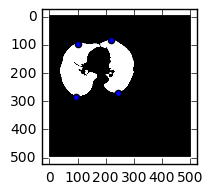

-5.277347051364199
slice 135
((87, 236), (208, 244), (97, 68), (209, 74))


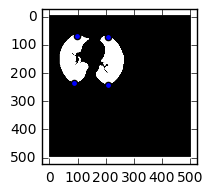

3.4245654738610973


In [1406]:
#discover lungs rotation
first_angle_rotation = discover_lung_rotation(first_segmented_lungs_fill_raw)
print(first_angle_rotation)

second_angle_rotation = discover_lung_rotation(second_segmented_lungs_fill_raw)
print(second_angle_rotation)

In [1472]:
from scipy.ndimage.interpolation import rotate

#print('first rotation')
#first_segmented_lungs_fill_rotated = rotate(first_segmented_lungs_fill_raw,first_angle_rotation,(1,2), reshape=False)
#first_pix_resampled_rotated = rotate(first_pix_resampled,first_angle_rotation,(1,2), reshape=False)

#print('second rotation')
#second_segmented_lungs_fill_rotated = rotate(second_segmented_lungs_fill_raw,second_angle_rotation,(1,2), reshape=False)
#second_pix_resampled_rotated = rotate(second_pix_resampled,second_angle_rotation,(1,2), reshape=False)

#SKIP ROTATION
first_segmented_lungs_fill_rotated = first_segmented_lungs_fill_raw
first_pix_resampled_rotated = first_pix_resampled

second_segmented_lungs_fill_rotated = second_segmented_lungs_fill_raw
second_pix_resampled_rotated = second_pix_resampled

slice1 135


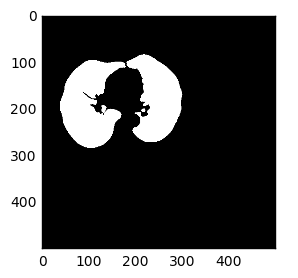

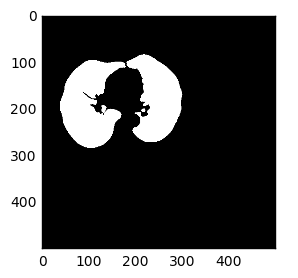

slice2 135


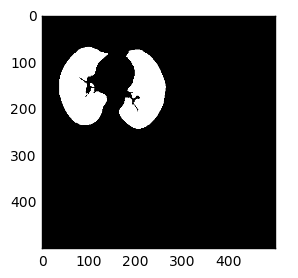

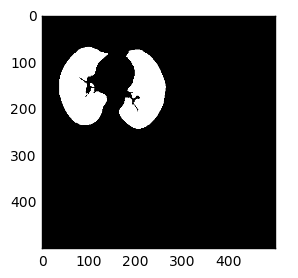

In [1473]:
bbox = boundingBox(first_segmented_lungs_fill_raw)
slice1 = int((bbox[1][2]-bbox[0][2])/2)
print('slice1', slice1)

plot_slice(first_segmented_lungs_fill_raw, None, None, pos=slice1, size=3)
plot_slice(first_segmented_lungs_fill_rotated, None, None, pos=slice1, size=3)

bbox = boundingBox(second_segmented_lungs_fill_raw)
slice2 = int((bbox[1][2]-bbox[0][2])/2)
print('slice2', slice2)

plot_slice(second_segmented_lungs_fill_raw, None, None, pos=slice2, size=3)
plot_slice(second_segmented_lungs_fill_rotated, None, None, pos=slice2, size=3)

Dilate lung mask a bit more to avoid small cracks and to avoid loosing important features on lung edges


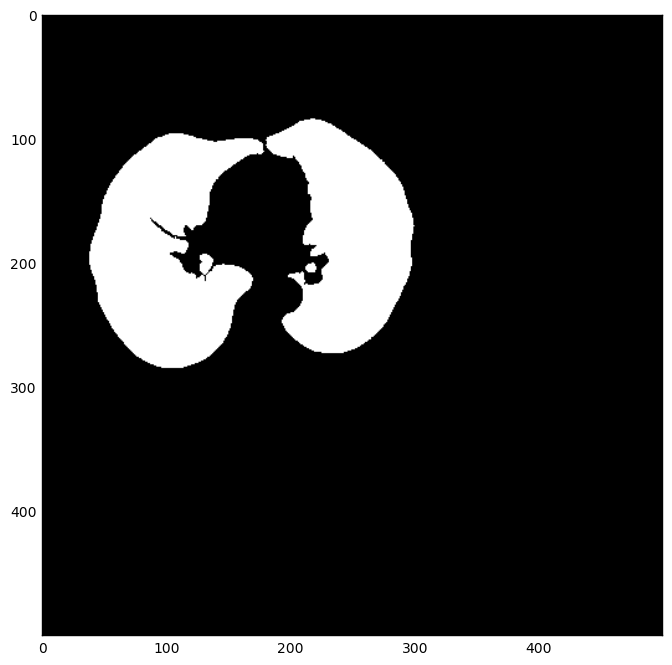

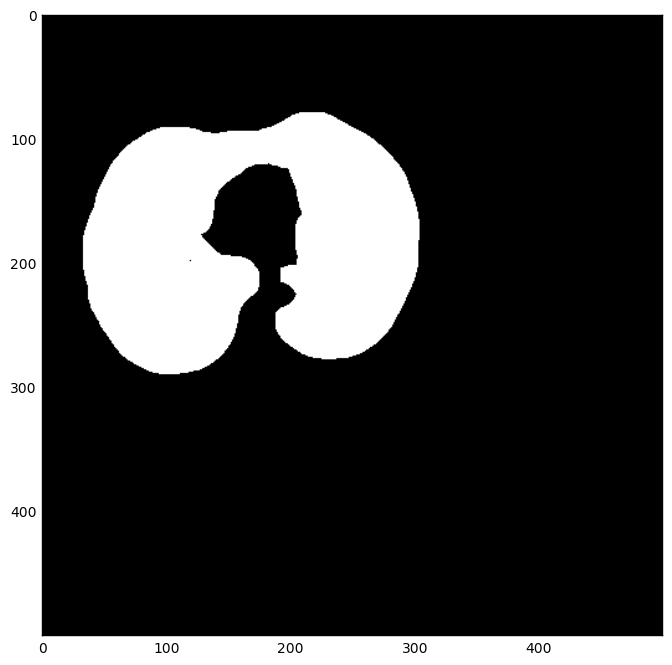

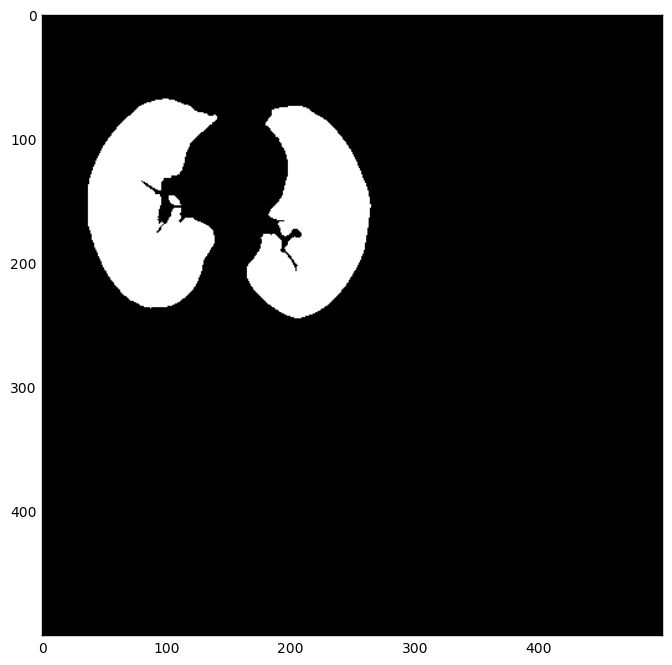

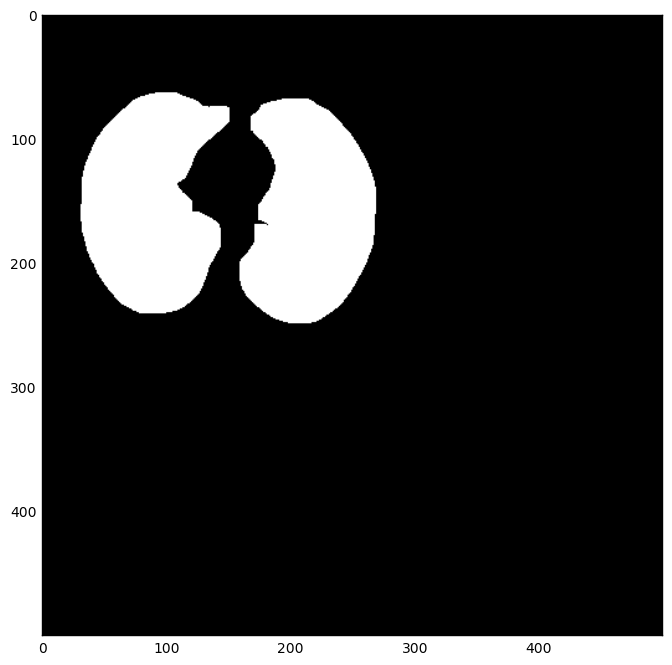

In [1474]:
print('Dilate lung mask a bit more to avoid small cracks and to avoid loosing important features on lung edges')
plot_slice(first_segmented_lungs_fill_rotated, pos=slice1)
first_segmented_lungs_fill_dilated = scipy.ndimage.morphology.grey_dilation(first_segmented_lungs_fill_rotated, size=(10,10,10))
plot_slice(first_segmented_lungs_fill_dilated, pos=slice1)

plot_slice(second_segmented_lungs_fill_rotated, pos=slice2)
second_segmented_lungs_fill_dilated = scipy.ndimage.morphology.grey_dilation(second_segmented_lungs_fill_rotated, size=(10,10,10))
plot_slice(second_segmented_lungs_fill_dilated, pos=slice2)


[(16, 64, 0), (310, 285, 271)]
271


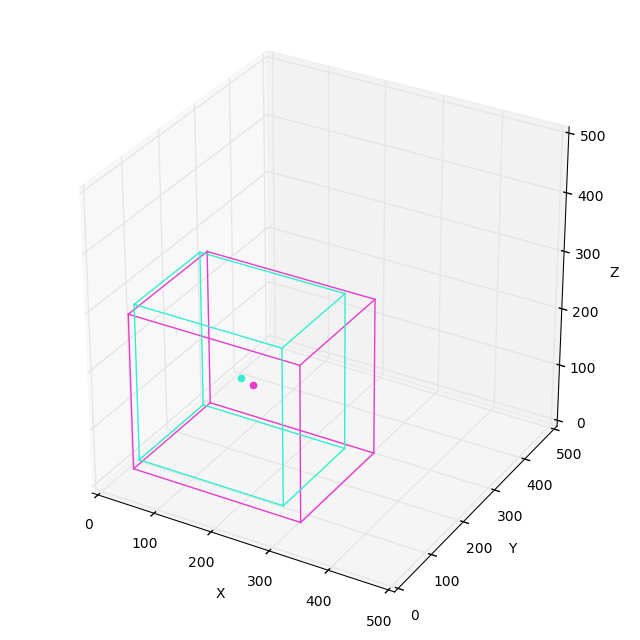

In [1475]:
first_bounding = boundingBox(first_segmented_lungs_fill_rotated)
second_bounding = boundingBox(second_segmented_lungs_fill_rotated)
print(first_bounding)
print(first_bounding[1][2]-first_bounding[0][2])

plot_boundingBox(np.array([first_bounding, second_bounding]))

Determine mean center positioning between first and second patient

In [1484]:
first_bounding_center = boundingBoxCenter(first_bounding)
second_bounding_center = boundingBoxCenter(second_bounding)

# mean_bounding_center = tuple(np.mean([first_bounding_center, second_bounding_center], axis=0).astype(np.int64))
mean_bounding_center = (250, 250, 250)
print('Mean center among patients', mean_bounding_center)

Mean center among patients (250, 250, 250)


Translate patients to the same (mean) bounding center

In [1477]:
def diffForShifting(point1, point2):
    t = np.subtract(point1, point2)
    return (t[2], t[1], t[0])

In [1478]:
from scipy.ndimage.interpolation import shift

first_translate_diff = diffForShifting(mean_bounding_center, first_bounding_center)
second_translate_diff = diffForShifting(mean_bounding_center, second_bounding_center)
print('Before centralization')
print(mean_bounding_center)
print(first_bounding_center)
print(second_bounding_center)
print(first_translate_diff)
print(second_translate_diff)

print('Moving volumes to center')
first_segmented_lungs_fill_centered = shift(first_segmented_lungs_fill_dilated,shift=first_translate_diff)
first_pix_resampled_centered = shift(first_pix_resampled_rotated,shift=first_translate_diff)

second_segmented_lungs_fill_centered = shift(second_segmented_lungs_fill_dilated,shift=second_translate_diff)
second_pix_resampled_centered = shift(second_pix_resampled_rotated,shift=second_translate_diff)


Before centralization
(250, 250, 250)
(163, 174, 136)
(156, 152, 158)
(114, 76, 87)
(92, 98, 94)
Moving volumes to center


In [1479]:
print('Plot after centralization')
first_bounding_centered = boundingBox(first_segmented_lungs_fill_centered)
second_bounding_centered = boundingBox(second_segmented_lungs_fill_centered)
print('first_bounding_centered', first_bounding_centered)

bb1 = boundingBoxCenter(first_bounding_centered)
bb2 = boundingBoxCenter(second_bounding_centered)

print('centers diff1', tuple(np.subtract(mean_bounding_center, bb1)))
print('centers diff2', tuple(np.subtract(mean_bounding_center, bb2)))

bb1a = first_bounding_centered
bb2a = second_bounding_centered
slice1 = int(bb1a[0][2]+(bb1a[1][2]-bb1a[0][2])/2)
slice2 = int(bb2a[0][2]+(bb2a[1][2]-bb2a[0][2])/2)
print('slice1', slice1)
print('slice1', slice2)


Plot after centralization
first_bounding_centered [(98, 135, 114), (401, 365, 389)]
centers diff1 (0, 0, -2)
centers diff2 (1, 0, 1)
slice1 251
slice1 249


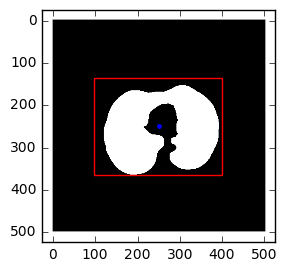

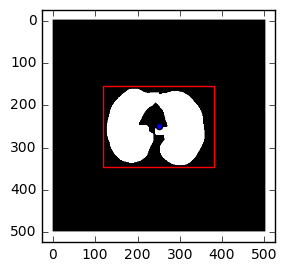

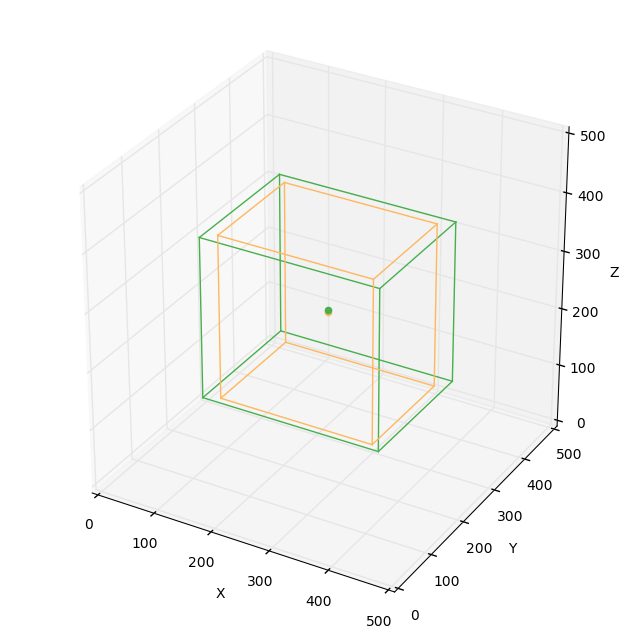

In [1480]:
plot_slice(first_segmented_lungs_fill_centered, mean_bounding_center, first_bounding_centered, pos=slice1, size=3)
plot_slice(second_segmented_lungs_fill_centered, mean_bounding_center, second_bounding_centered, pos=slice2, size=3)
plot_boundingBox(np.array([first_bounding_centered, second_bounding_centered]))

Apply lung mask to original image

In [1481]:
first_masked_pix = np.ma.masked_where(first_segmented_lungs_fill_centered==0, first_pix_resampled_centered)
second_masked_pix = np.ma.masked_where(second_segmented_lungs_fill_centered==0, second_pix_resampled_centered)

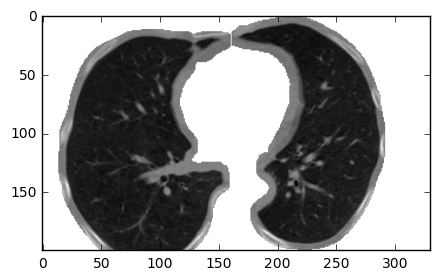

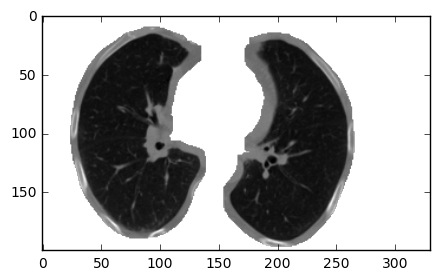

In [1482]:
for i in range(1):
  plot_slice(first_masked_pix[:,150:350,100:430], pos=220 + i*10, size=5)
  plot_slice(second_masked_pix[:,150:350,100:430], pos=220 + i*10, size=5)

In [1483]:
#plot_3d(segmented_lungs_fill, 0)

That's better. Let's also visualize the difference between the two.

In [19]:
#plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [68]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [69]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image